In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import json

In [2]:
# Image size and batch size
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_path = 'C:/Users/AJ/OneDrive/Desktop/school/Neural Networks and Deep Learning/Weeds and Crops Classification/dataset_2_split/train'
val_path = 'C:/Users/AJ/OneDrive/Desktop/school/Neural Networks and Deep Learning/Weeds and Crops Classification/dataset_2_split/validation'
test_path = 'C:/Users/AJ/OneDrive/Desktop/school/Neural Networks and Deep Learning/Weeds and Crops Classification/dataset_2_split/test'

In [3]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_data = train_datagen.flow_from_directory(train_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='sparse')
val_data = val_test_datagen.flow_from_directory(val_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='sparse')
test_data = val_test_datagen.flow_from_directory(test_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='sparse', shuffle=False)

Found 6407 images belonging to 12 classes.
Found 1368 images belonging to 12 classes.
Found 1369 images belonging to 12 classes.


In [5]:
# Define a simplified VGG16-based model
def build_vgg16_simple(input_shape=(128, 128, 3), num_classes=12):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model to use it as a feature extractor

    # Add custom layers for classification
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

vgg16_model = build_vgg16_simple()

In [6]:
vgg16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 12)                3084      
                                                                 
Total params: 16,815,180
Trainable params: 2,100,492
Non-trainable params: 14,714,688
_________________________________________________________________


In [6]:
history_vgg16 = vgg16_model.fit(train_data, validation_data=val_data, epochs=50)

Epoch 1/50
201/201 [==============================] - 77s 342ms/step - loss: 1.8626 - accuracy: 0.3555 - val_loss: 1.6109 - val_accuracy: 0.4415
Epoch 2/50
201/201 [==============================] - 40s 199ms/step - loss: 1.4963 - accuracy: 0.4779 - val_loss: 1.3779 - val_accuracy: 0.5468
Epoch 3/50
201/201 [==============================] - 39s 192ms/step - loss: 1.3327 - accuracy: 0.5266 - val_loss: 1.3516 - val_accuracy: 0.5322
Epoch 4/50
201/201 [==============================] - 42s 207ms/step - loss: 1.2499 - accuracy: 0.5583 - val_loss: 1.2071 - val_accuracy: 0.6038
Epoch 5/50
201/201 [==============================] - 40s 200ms/step - loss: 1.1843 - accuracy: 0.5869 - val_loss: 1.1372 - val_accuracy: 0.5950
Epoch 6/50
201/201 [==============================] - 40s 200ms/step - loss: 1.1291 - accuracy: 0.6000 - val_loss: 1.0950 - val_accuracy: 0.6118
Epoch 7/50
201/201 [==============================] - 40s 199ms/step - loss: 1.1087 - accuracy: 0.6134 - val_loss: 1.1121 - val_ac

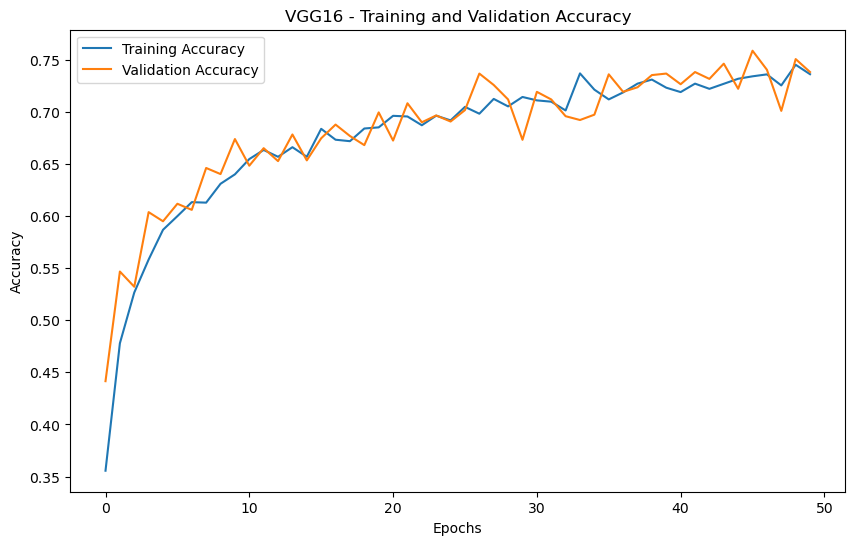

In [7]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history_vgg16.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('VGG16 - Training and Validation Accuracy')
plt.show()

In [8]:
# Evaluate on Test Data
test_loss, test_accuracy = vgg16_model.evaluate(test_data)
print(f'VGG16 Test Accuracy: {test_accuracy * 100:.2f}%')

43/43 [==============================] - 19s 437ms/step - loss: 0.7924 - accuracy: 0.7173
VGG16 Test Accuracy: 71.73%


43/43 [==============================] - 25s 569ms/step


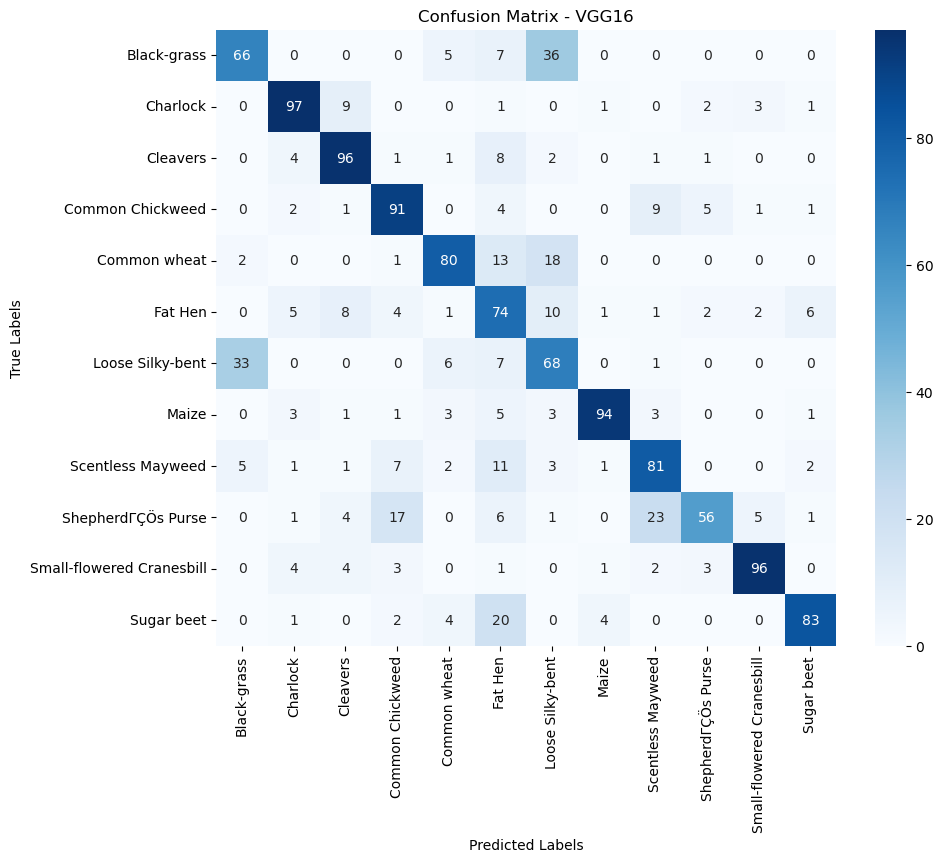

In [9]:
# Confusion Matrix and Classification Report
predictions = np.argmax(vgg16_model.predict(test_data), axis=1)
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

# Plot Confusion Matrix
cm = confusion_matrix(true_classes, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - VGG16')
plt.show()

In [10]:
print("Classification Report for VGG16")
print(classification_report(true_classes, predictions, target_names=class_labels))

Classification Report for VGG16
                           precision    recall  f1-score   support

              Black-grass       0.62      0.58      0.60       114
                 Charlock       0.82      0.85      0.84       114
                 Cleavers       0.77      0.84      0.81       114
         Common Chickweed       0.72      0.80      0.76       114
             Common wheat       0.78      0.70      0.74       114
                  Fat Hen       0.47      0.65      0.55       114
         Loose Silky-bent       0.48      0.59      0.53       115
                    Maize       0.92      0.82      0.87       114
        Scentless Mayweed       0.67      0.71      0.69       114
       ShepherdΓÇÖs Purse       0.81      0.49      0.61       114
Small-flowered Cranesbill       0.90      0.84      0.87       114
               Sugar beet       0.87      0.73      0.79       114

                 accuracy                           0.72      1369
                macro avg   

In [11]:
# Save the model
vgg16_model.save("vgg16_model.h5")
print("VGG16 model saved as 'vgg16_model.h5'")

VGG16 model saved as 'vgg16_model.h5'


In [12]:
# Save training metadata
metadata = {
    "train_accuracy": history_vgg16.history['accuracy'][-1],  # Last epoch's training accuracy
    "val_accuracy": history_vgg16.history['val_accuracy'][-1],  # Last epoch's validation accuracy
    "test_accuracy": test_accuracy,  # Test accuracy
    "num_classes": len(train_data.class_indices),  # Number of classes
    "class_indices": train_data.class_indices
}

with open("vgg16_model_metadata.json", "w") as metadata_file:
    json.dump(metadata, metadata_file, indent=4)

print("VGG16 metadata saved as 'vgg16_model_metadata.json'")

VGG16 metadata saved as 'vgg16_model_metadata.json'
